{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}


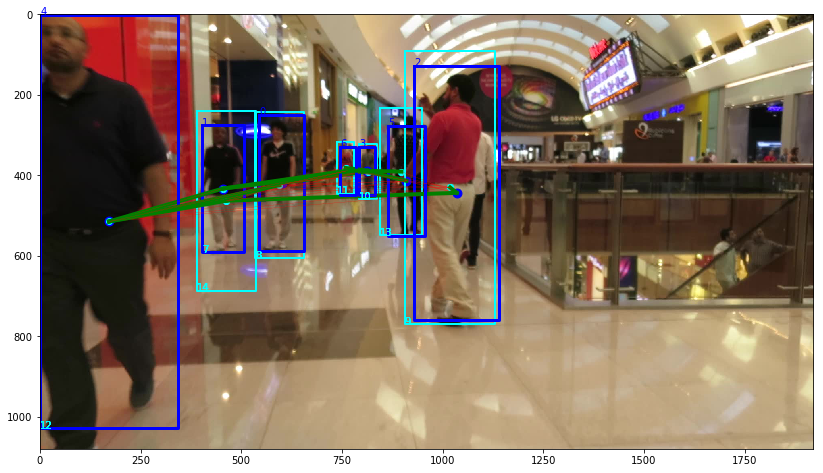

In [1]:
%matplotlib inline
import json
from pppr import aabb
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np
from pak.evaluation import MOTA

root = Settings['data_root']

from experiments import MOT16_Experiments

mot16 = MOT16_Experiments(root)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

# --- SELECT THE RIGHT VIDEO ----
X  = mot16.mot16_11_X
#Dt = mot16.mot16_11_true_detections_no_pid
Dt = mot16.mot16_11_detections

#E = np.loadtxt('edges.txt')
E = np.loadtxt('../build/edges.txt')

def find_cost(i, j, E):
    for a, b, ce in E:
        if int(a) == int(i) and int(b) == int(j):
            return ce
    assert False

FIRST_FRAME = 1
SECOND_FRAME = FIRST_FRAME + 1
    
indx_frame1 = []
indx_frame2 = []
for idx, dt in enumerate(Dt):
    if dt[0] == FIRST_FRAME:
        indx_frame1.append(idx)
    elif dt[0] == SECOND_FRAME:
        indx_frame2.append(idx)

        
def get_center(aabb):
    _, x,y,w,h,_ = aabb
    return (x+w/2, y+h/2)
        
for j in indx_frame2:
    frame2, x, y, w, h, _ = Dt[j]
    assert frame2 == SECOND_FRAME
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=2, c='cyan')
        

for i in indx_frame1:
    frame1, x, y, w, h, score = Dt[i]
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, c='blue')
    c_i = get_center(Dt[i])
    ax.scatter(c_i[0], c_i[1], color='blue', s=80)
    ax.text(Dt[i][1], Dt[i][2], str(i), color='blue')
    assert frame1 == FIRST_FRAME
    for j in indx_frame2:
        c_j = get_center(Dt[j])
        ax.scatter(c_j[0], c_j[1], color='cyan', s=30)
        ax.text(Dt[j][1], Dt[j][2]+Dt[j][4], str(j), color='cyan')
        
        ce = find_cost(i, j, E)
        color = 'green' if ce > 0 else 'red'
        lw = 4 if ce > 0 else 0.2
        ax.plot([c_i[0], c_j[0]], [c_i[1], c_j[1]], color=color, lw=lw)


ax.imshow(X[FIRST_FRAME])
plt.show()

In [2]:
from pppr import aabb

E = np.loadtxt('../build/edges.txt')
LAST_NODE = int(np.max(E[:,1]))

print(mot16.mot16_11_detections.shape)

PAIRING = []
for i,j,value in E:
    i = int(i); j = int(j)
    PAIRING.append(
        ((i, j),
        mot16.mot16_11_detections[i],
        mot16.mot16_11_detections[j],
         value))

for pair, left, right, value in PAIRING:
    if value > 0:
        print("value:", value)
        print(pair)
        print(left.astype('object'))
        print(right.astype('object'))
        print('')

(8125, 6)
value: 9.89336620373
(0, 5)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[1.0 864.82 276.69 90.896 274.69 0.21276]

value: 7.73854628227
(0, 10)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[2.0 791.3 322.64 44.948 136.84 0.88734]

value: 9.8766989457
(0, 14)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[2.0 389.14 239.86 148.29 446.86 -0.40773]

value: 9.56260288707
(0, 19)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[3.0 335.87 651.04 48.246 146.74 -0.4938]

value: 9.76102643052
(0, 24)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[4.0 848.03 257.08 97.492 294.47 -0.035064]

value: 10.3487276979
(0, 28)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[5.0 381.02 275.46 104.56 315.68 3.1284]

value: 8.64624801255
(0, 33)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[5.0 454.06 857.88 48.246 146.74 -0.4977]

value: 9.07088803365
(0, 39)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[6.0 726.98 313.45 44.948 136.84 -0.39849]

value: 10.4134941097
(0, 45)
[1.0 544.06 249.9 112.14 338.41 1.8821]
[7.0 726.98 313.45 44.948

[18.0 446.86 206.78 170.48 513.45 -0.40818]

value: 1.23643074162
(13, 173)
[2.0 845.49 233.23 104.56 315.68 -0.34506]
[19.0 669.79 352.54 41.871 127.61 0.063775]

value: 1.77990184043
(13, 177)
[2.0 845.49 233.23 104.56 315.68 -0.34506]
[20.0 468.86 260.92 128.96 388.88 2.4399]

value: 9.3781001578
(14, 18)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[3.0 887.71 127.67 210.12 632.36 0.82768]

value: 9.93265408063
(14, 24)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[4.0 848.03 257.08 97.492 294.47 -0.035064]

value: 11.4546708912
(14, 29)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[5.0 528.8 254.35 104.56 315.68 1.6376]

value: 14.6722745537
(14, 34)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[6.0 364.77 243.51 120.26 362.77 3.1023]

value: 11.793709825
(14, 39)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[6.0 726.98 313.45 44.948 136.84 -0.39849]

value: 15.7243699581
(14, 45)
[2.0 389.14 239.86 148.29 446.86 -0.40773]
[7.0 726.98 313.45 44.948 136.84 -0.2875]

value: 18.5161573712
(14,

value: 5.99813495787
(35, 69)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[10.0 498.8 249.9 112.14 338.41 1.8936]

value: 5.08830988652
(35, 76)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[10.0 850.66 363.15 68.644 207.93 -0.47649]

value: 14.4291805418
(35, 83)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[11.0 403.99 927.01 41.871 127.61 0.052148]

value: 4.21792896216
(35, 88)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[12.0 498.8 249.9 112.14 338.41 2.2955]

value: 0.908445548785
(35, 94)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[12.0 405.34 929.15 44.948 136.84 -0.19211]

value: 1.65422546129
(35, 95)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[12.0 1025.0 417.0 79.0 239.0 -0.19444]

value: 2.48842173993
(35, 178)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[20.0 845.49 169.9 210.12 632.36 1.9406]

value: 2.59470638921
(35, 179)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[20.0 317.78 295.16 112.14 338.41 1.7752]

value: 2.6118591072
(35, 182)
[6.0 521.43 249.9 112.14 338.41 1.7228]
[20.0 772.68 343.97 41.8

[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[9.0 781.25 326.82 41.871 127.61 1.2758]

value: 6.55410400243
(56, 62)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[9.0 717.79 313.45 44.948 136.84 0.50389]

value: 7.4567375948
(56, 69)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[10.0 498.8 249.9 112.14 338.41 1.8936]

value: 8.29147736711
(56, 75)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[10.0 321.0 193.0 159.0 479.0 -0.3011]

value: 4.24880147991
(56, 77)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[11.0 498.8 249.9 112.14 338.41 2.5106]

value: 9.83341418242
(56, 80)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[11.0 769.23 326.02 48.246 146.74 0.94923]

value: 9.46096020241
(56, 86)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[11.0 1673.5 534.0 90.896 274.69 -0.32521]

value: 13.0090113967
(56, 91)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[12.0 673.0 345.0 39.0 119.0 0.92141]

value: 3.80020875435
(56, 97)
[8.0 1665.0 545.0 79.0 239.0 -0.44968]
[12.0 825.0 337.0 39.0 119.0 -0.23757]

value: 7.47892131615
(56, 98)
[8.0 1


value: 6.04704170106
(77, 80)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[11.0 769.23 326.02 48.246 146.74 0.94923]

value: 6.71117840265
(77, 85)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[11.0 542.7 848.03 48.246 146.74 -0.28698]

value: 8.08202779285
(77, 90)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[12.0 772.93 331.83 44.948 136.84 1.0386]

value: 5.67582091369
(77, 95)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[12.0 1025.0 417.0 79.0 239.0 -0.19444]

value: 6.58118659735
(77, 100)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[12.0 828.33 473.76 195.98 589.95 -0.43869]

value: 7.05494411306
(77, 105)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[13.0 669.79 335.39 41.871 127.61 1.4184]

value: 9.56107886588
(77, 110)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[13.0 825.0 337.0 39.0 119.0 -0.018165]

value: 1.61589764063
(77, 216)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[23.0 1783.8 552.38 90.896 274.69 -0.47993]

value: 2.31736685677
(77, 245)
[11.0 498.8 249.9 112.14 338.41 2.5106]
[26.0 971.06 146.5

value: 0.393467539488
(98, 103)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[13.0 486.03 243.51 120.26 362.77 2.8739]

value: 0.0196277361149
(98, 107)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[13.0 860.84 136.76 225.27 677.82 0.86867]

value: 0.00781388193179
(98, 108)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[13.0 710.14 316.17 48.246 146.74 0.69135]

value: 0.530681380174
(98, 112)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[13.0 520.84 858.74 63.98 193.94 -0.35165]

value: 3.66024608995
(98, 118)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[14.0 860.84 136.76 225.27 677.82 1.0522]

value: 0.88062176595
(98, 122)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[14.0 825.0 337.0 39.0 119.0 0.24837]

value: 3.57724908365
(98, 123)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[14.0 321.0 225.0 159.0 479.0 -0.041956]

value: 2.72212263868
(98, 127)
[12.0 1358.6 227.27 55.569 168.71 -0.25789]
[15.0 860.84 136.76 225.27 677.82 1.1412]

value: 9.07328817044
(98, 128)
[12.0 1358.6 227.27 


value: 6.89923602289
(119, 137)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[16.0 860.84 136.76 225.27 677.82 0.9065]

value: 8.96060372859
(119, 141)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[16.0 712.66 326.82 41.871 127.61 0.071869]

value: 9.61063221838
(119, 146)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[16.0 736.17 386.96 44.948 136.84 -0.45909]

value: 12.3121631409
(119, 152)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[17.0 669.79 343.97 41.871 127.61 0.4458]

value: 7.81334000114
(119, 157)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[17.0 1115.6 309.67 84.742 256.23 -0.30078]

value: 8.28007694926
(119, 162)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[18.0 777.0 337.0 39.0 119.0 0.53077]

value: 7.08783721209
(119, 167)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[18.0 1115.6 309.67 84.742 256.23 -0.40336]

value: 2.84944850719
(119, 173)
[14.0 669.79 335.39 41.871 127.61 0.98376]
[19.0 669.79 352.54 41.871 127.61 0.063775]

value: 6.21632746021
(119, 178)
[14.0 669.79 335.

[22.0 552.38 938.34 44.948 136.84 -0.3724]

value: 17.8715589323
(138, 207)
[16.0 777.0 329.0 39.0 119.0 0.56491]
[23.0 887.71 169.9 210.12 632.36 1.7704]

value: 6.61919294551
(138, 210)
[16.0 777.0 329.0 39.0 119.0 0.56491]
[23.0 704.08 361.12 41.871 127.61 0.01154]

value: 18.2457721372
(138, 213)
[16.0 777.0 329.0 39.0 119.0 0.56491]
[23.0 251.72 321.36 68.644 207.93 -0.25727]

value: 5.05314002089
(138, 217)
[16.0 777.0 329.0 39.0 119.0 0.56491]
[24.0 364.89 286.91 128.96 388.88 2.6667]

value: 13.6188726207
(139, 144)
[16.0 669.79 343.97 41.871 127.61 0.18371]
[16.0 824.12 335.39 41.871 127.61 -0.051983]

value: 14.2552591207
(139, 149)
[16.0 669.79 343.97 41.871 127.61 0.18371]
[17.0 887.71 169.9 210.12 632.36 1.3199]

value: 12.7840153165
(139, 154)
[16.0 669.79 343.97 41.871 127.61 0.18371]
[17.0 1358.6 227.27 55.569 168.71 -0.13781]

value: 14.3888919504
(139, 159)
[16.0 669.79 343.97 41.871 127.61 0.18371]
[18.0 486.03 267.77 120.26 362.77 2.7171]

value: 13.7100258526
(139,

[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[20.0 1041.9 589.31 55.569 168.71 -0.38086]

value: 11.7370801008
(154, 192)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[21.0 788.93 345.72 48.246 146.74 -0.29387]

value: 9.35662062154
(154, 195)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[22.0 494.85 260.92 128.96 388.88 2.0764]

value: 12.3735302402
(154, 198)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[22.0 860.84 136.76 225.27 677.82 1.3194]

value: 14.8960157923
(154, 203)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[22.0 455.43 524.03 41.871 127.61 -0.47548]

value: 9.42278065848
(154, 205)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[23.0 510.28 292.02 120.26 362.77 1.9211]

value: 14.8285127247
(154, 208)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[23.0 749.54 345.72 48.246 146.74 0.29533]

value: 7.96154873797
(154, 211)
[17.0 1358.6 227.27 55.569 168.71 -0.13781]
[23.0 481.15 241.08 170.48 513.45 -0.13872]

value: 13.1048847947
(154, 215)
[17.0 1358.6 227.27 55.569 168.71 -0.13

[19.0 1116.6 389.02 59.629 180.89 -0.020975]
[27.0 1456.1 231.39 59.629 180.89 -0.28502]

value: 11.6809370779
(175, 180)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[20.0 669.79 352.54 41.871 127.61 0.54027]

value: 10.3338161567
(175, 186)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[20.0 1041.9 589.31 55.569 168.71 -0.38086]

value: 13.4514494858
(175, 192)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[21.0 788.93 345.72 48.246 146.74 -0.29387]

value: 6.60448187132
(175, 195)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[22.0 494.85 260.92 128.96 388.88 2.0764]

value: 11.4244596262
(175, 198)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[22.0 860.84 136.76 225.27 677.82 1.3194]

value: 11.5533907611
(175, 203)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[22.0 455.43 524.03 41.871 127.61 -0.47548]

value: 6.13900384776
(175, 205)
[19.0 710.14 335.87 48.246 146.74 -0.17267]
[23.0 510.28 292.02 120.26 362.77 1.9211]

value: 11.714851931
(175, 208)
[19.0 710.14 335.87 48.246 146.74 -0.17

[21.0 719.99 345.72 48.246 146.74 -0.38964]
[23.0 817.0 361.0 39.0 119.0 0.21612]

value: 9.63590396672
(193, 214)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[23.0 1404.6 442.87 63.98 193.94 -0.39423]

value: 9.73136499241
(193, 220)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[24.0 887.71 169.9 210.12 632.36 1.573]

value: 9.78856579579
(193, 225)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[25.0 1031.7 251.72 138.29 416.86 2.1186]

value: 10.2707512107
(193, 231)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[25.0 1003.9 711.37 68.644 207.93 -0.23687]

value: 10.1824138991
(193, 235)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[25.0 806.97 429.71 41.871 127.61 -0.48561]

value: 7.98439071208
(193, 241)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[26.0 791.3 350.2 44.948 136.84 0.1843]

value: 9.18590373222
(193, 247)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[27.0 391.01 279.58 138.29 416.86 3.2927]

value: 11.8424182843
(193, 252)
[21.0 719.99 345.72 48.246 146.74 -0.38964]
[27.0 7

(218, 250)
[24.0 1031.7 251.72 138.29 416.86 2.2854]
[27.0 887.71 169.9 210.12 632.36 1.3459]

value: 9.9026185946
(218, 254)
[24.0 1031.7 251.72 138.29 416.86 2.2854]
[27.0 971.06 146.51 241.51 726.54 -0.28663]

value: 8.59756397187
(218, 258)
[24.0 1031.7 251.72 138.29 416.86 2.2854]
[28.0 572.83 286.91 128.96 388.88 1.8485]

value: 9.11649227746
(218, 262)
[24.0 1031.7 251.72 138.29 416.86 2.2854]
[28.0 866.6 359.91 51.78 157.34 -0.24783]

value: 6.20018127166
(218, 266)
[24.0 1031.7 251.72 138.29 416.86 2.2854]
[29.0 558.15 279.58 138.29 416.86 1.8667]

value: 6.93461912618
(219, 223)
[24.0 520.84 286.91 128.96 388.88 2.073]
[24.0 759.38 345.72 48.246 146.74 -0.18841]

value: 13.2552318633
(219, 224)
[24.0 520.84 286.91 128.96 388.88 2.073]
[25.0 363.15 279.58 138.29 416.86 2.777]

value: 4.95044860419
(219, 228)
[24.0 520.84 286.91 128.96 388.88 2.073]
[25.0 849.0 361.0 39.0 119.0 0.20442]

value: 13.6226268365
(219, 229)
[24.0 520.84 286.91 128.96 388.88 2.073]
[25.0 737.0 377.0 

In [3]:
from cabbage.data.video import VideoData
from pak.evaluation import MOTA


# calculate MOTA
Gt = mot16.get_MOT16_11_gt_trajectories()
vd = VideoData(Gt)
Gt = vd.get_n_first_frames(10)

# test against "TRUE" detections
Hy = mot16.get_MOT16_11_trajectories()  # true detections
result, info = MOTA.evaluate_aabb(Gt, Hy, threshold, info=True)

print('true detection')
print("\tResult:", result)
print("\tInfo:", info)

vd = VideoData(mot16.mot16_11_true_detections_no_pid)
Hy_ = vd.get_n_first_frames(10)

Hy = []
assert Hy_.shape[0] == len(Nodes)
for (frame, x, y, w, h, score),pid in zip(Hy_, Nodes):
    Hy.append((frame, pid, x, y, w, h))
Hy = np.array(Hy)
threshold = 0.5


result, info = MOTA.evaluate_aabb(Gt, Hy, threshold, info=True)

print('our prediction')
print("\tResult:", result)
print("\tInfo:", info)

NameError: name 'threshold' is not defined